<Figure size 1600x1600 with 0 Axes>

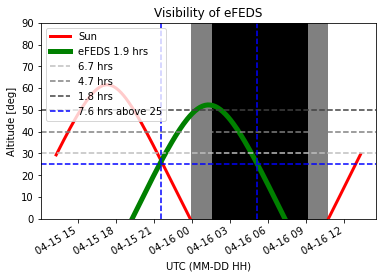

In [1]:
import pandas as pd
import astropy.coordinates as apc
import os
from datetime import datetime
import numpy as np
from astroquery.jplhorizons import Horizons
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import Angle
import M2_vis_plot
import make_el_chart as mec
import astropy.coordinates as apc
import os
import matplotlib.pyplot as plt

In [2]:
dfs = pd.read_html("http://www.johnstonsarchive.net/astro/tnodiam.html")
df_TNO=dfs[1]
df_TNO = df_TNO[['number/name', 'prov. des.','type','effectivediameter (km)','primarydiameter (km)','albedo','meth','source']]
tno_types = ["CUB","HAU","SDO","TNO"]
df_TNO = df_TNO.dropna(subset=['effectivediameter (km)', 'albedo'])
df_TNO_johnston = df_TNO.loc[df_TNO['type'].isin(tno_types)]

In [3]:
TNO_johnston_names = np.array(df_TNO_johnston['prov. des.'])
TNO_dict = {}
for i in range(len(TNO_johnston_names)):
    obj = Horizons(id=TNO_johnston_names[i], location='568',epochs={'start':'2022-01-31', 'stop':'2022-02-15','step':'7d'})
    eph = obj.ephemerides()
    datetime_str_array=np.array(eph['datetime_str'])
    ra_array=np.array(eph['RA'])
    dec_array=np.array(eph['DEC'])
    TNO_dict[TNO_johnston_names[i]]={
        "datetime_str": datetime_str_array,
        "RA" : ra_array,
        "DEC" : dec_array
    }

In [4]:
RA_0131_johnston =[]
DEC_0131_johnston = []
for i in TNO_johnston_names:
    RA_0131_johnston = np.append(RA_0131_johnston,TNO_dict[i]["RA"][0])
    DEC_0131_johnston = np.append(DEC_0131_johnston,TNO_dict[i]["DEC"][0])
    
df_TNO_johnston['RA_0131'] = RA_0131_johnston
df_TNO_johnston['DEC_0131'] = DEC_0131_johnston
df_TNO_johnston_dec013122_cuts = df_TNO_johnston.loc[df_TNO_johnston['DEC_0131']>-15.0]

<ipython-input-4-8e301b52a4af>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TNO_johnston['RA_0131'] = RA_0131_johnston
<ipython-input-4-8e301b52a4af>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TNO_johnston['DEC_0131'] = DEC_0131_johnston


In [5]:
df_TNO_johnston_dec013122_cuts

,number/name,prov. des.,type,effectivediameter (km),primarydiameter (km),albedo,meth,source,RA_0131,DEC_0131
57,(15874),1996 TL66,SDO,632±84/98,NaN,0.03±0.012/0.007 *,T,T00a,81.09585,5.66180
58,(15874),1996 TL66,SDO,<958,NaN,>0.018 R,T*,G05a,81.09585,5.66180
59,(15874),1996 TL66,SDO,<958,NaN,>0.018 V,T,C06a,81.09585,5.66180
60,(15874),1996 TL66,SDO,575±116/115,NaN,0.035±0.02/0.011 V,T,S08a,81.09585,5.66180
61,(15874),1996 TL66,SDO,339±20,NaN,0.11±0.021/0.015 V,T,S12a,81.09585,5.66180
...,...,...,...,...,...,...,...,...,...,...
618,NaN,2001 QS322,CUB,<200,NaN,>0.15 V,T,B09a,13.13716,5.74807
619,NaN,2001 QS322,CUB,186±99/24,NaN,0.095±0.531/0.060 V,T,V14a,13.13716,5.74807
628,NaN,2002 GH32,TNO,<230,NaN,>0.075 V,T,V14a,237.78926,-11.96178
662,NaN,2010 WG9,SDO,112.7±61.9,NaN,0.074±0.08,T,B13b,92.76696,28.44276


In [6]:
df_TNO_full_list = pd.read_csv("TNO_final_cat.txt",dtype={'Prov.': str, 'Des.': str},delim_whitespace=True)
df_TNO_full_list["Prov. Des."] = df_TNO_full_list["prov."].astype(str) + " "+df_TNO_full_list["des."].astype(str)

In [17]:
cat = pd.merge(
    df_TNO_johnston_dec013122_cuts,
    df_TNO_full_list,
    how="inner",
    on=None,
    left_on= 'prov. des.',
    right_on='Prov. Des.',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [18]:
cat['measured_diameter']=cat['effectivediameter (km)'].map(lambda x: x.lstrip('<')).map(lambda x: x.lstrip('[')).map(lambda x: x.rstrip(']')).str.replace('±\d+.\d+/\d+.\d+', '').str.replace('±\d+.\d+','').str.replace('±\d+','')

In [19]:
cat['measured_diameter'] = cat['measured_diameter'].astype('float')

In [20]:
AU=1.495978707*10**11 
cat["ang_size_radians"] = 2*np.arctan((cat['measured_diameter']*10**3/2)/(cat['a'].astype(float)*AU))
cat["ang_size_arcsec"] = (cat["ang_size_radians"]*360/(2*np.pi))*3600

In [21]:
cat_size_cuts= cat.loc[cat['ang_size_arcsec']>0.01]

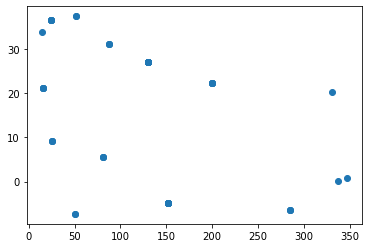

In [22]:
plt.scatter(cat_size_cuts['RA_0131'],cat_size_cuts['DEC_0131'])

/Users/karenperezsarmiento/Desktop/planet9/make_el_chart.py:209: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(1,dpi=dpi,figsize=(8,8));    plt.clf();    fig1,ax1 = plt.subplots()
/Users/karenperezsarmiento/Desktop/planet9/make_el_chart.py:209: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(1,dpi=dpi,figsize=(8,8));    plt.clf();    fig1,ax1 = plt.subplots()
/Users/karenperezsarmiento/Desktop/planet9/make_el_chart.py:209: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`m

IndexError: index 23 is out of bounds for axis 0 with size 23

<Figure size 1600x1600 with 0 Axes>

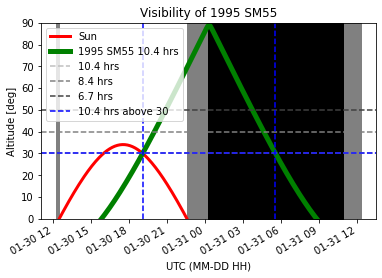

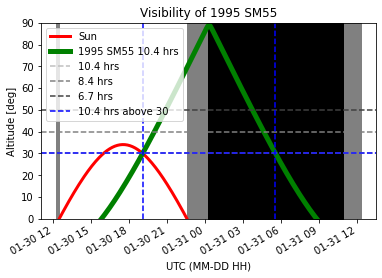

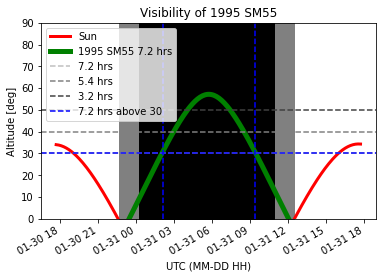

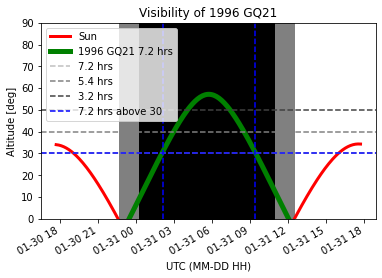

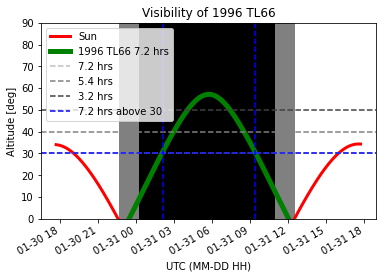

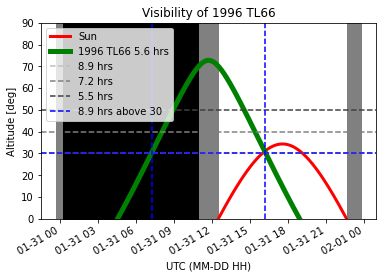

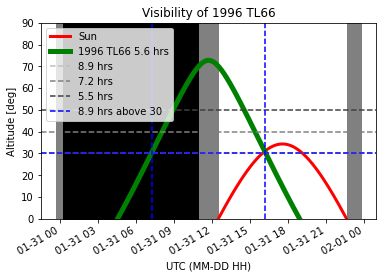

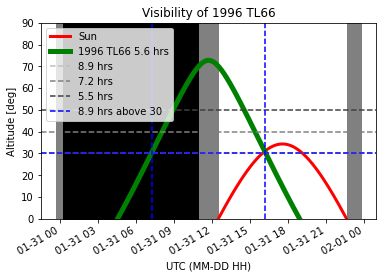

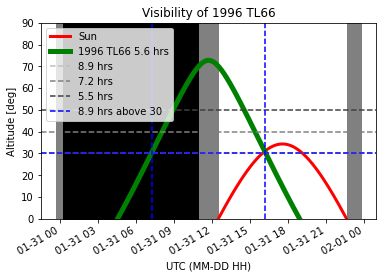

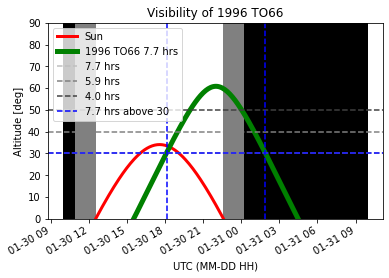

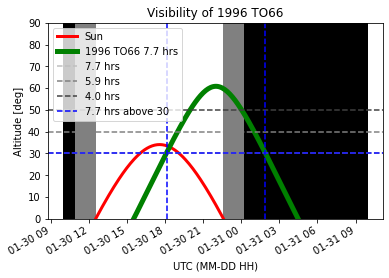

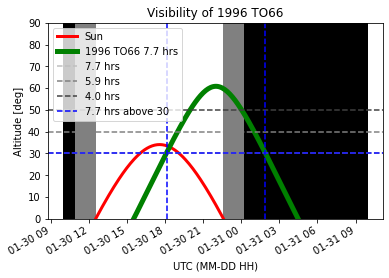

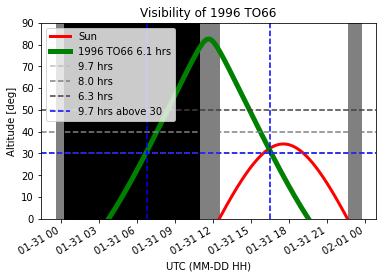

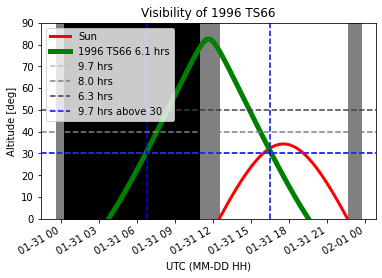

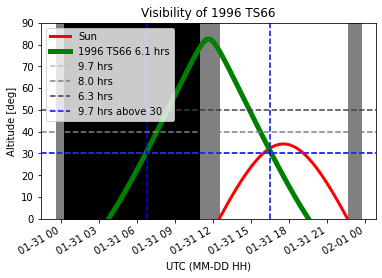

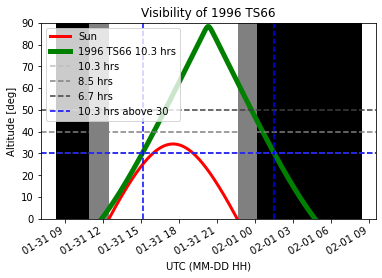

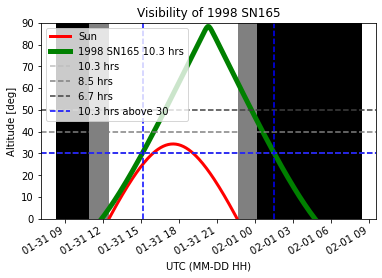

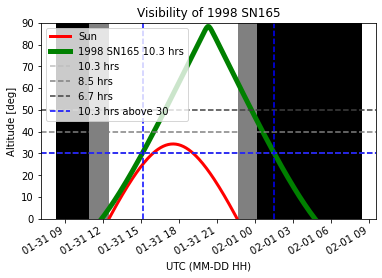

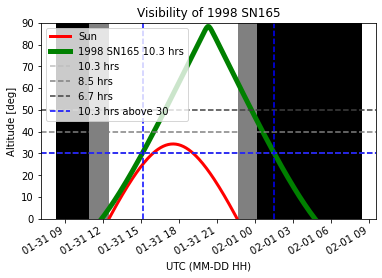

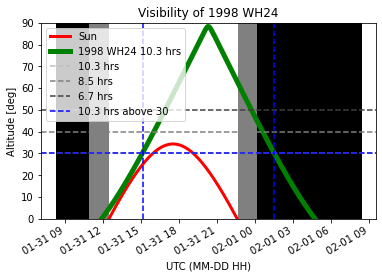

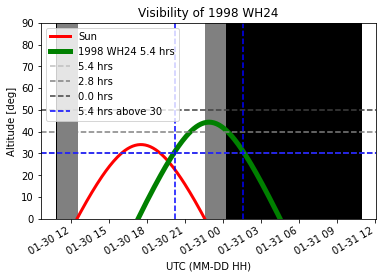

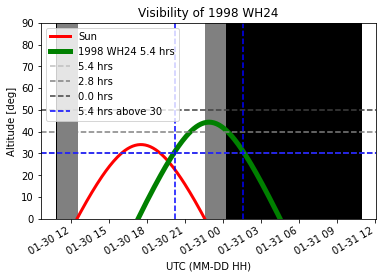

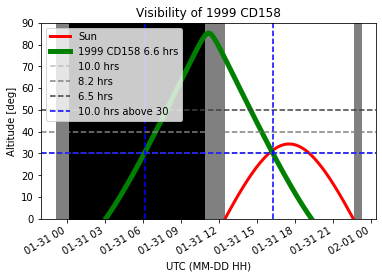

In [23]:
obj_ra = cat_ra_size_cuts['RA_0131'].map(lambda x: apc.Angle(str(x)+'h'))
obj_dec = cat_ra_size_cuts['DEC_0131'].map(lambda x: apc.Angle(str(x)+'d'))
skyobj = apc.SkyCoord(obj_ra,obj_dec,equinox='J2000')
target = np.array(cat['prov. des.'])
elMin=30.0
elStr = str(int(elMin))
date_obs  = datetime.strptime('31-01-2022 12:00:00', '%d-%m-%Y %H:%M:%S')
mydir = os.getcwd()
for i in range(len(target)):
    mec.plot_visibility(date_obs,skyobj[i],elMin=elMin,
                    mylabel=target[i],filename = target[i]+date_obs.strftime('%d%b%Y')+"_Visibility_above"+elStr,
                    mydir='largest_ang_size/')